# 🐱🐶 개와 고양이 분류 CNN 모델

이 노트북은 Convolutional Neural Network(CNN)을 사용하여 개와 고양이를 분류하는 딥러닝 모델을 구현합니다.

## 📋 프로젝트 개요
- **🎯 목표**: CNN을 사용한 개와 고양이 이미지 이진 분류
- **📊 데이터**: Kaggle cats_and_dogs 데이터셋 (25,000장)
- **🔧 모델**: Custom CNN with Data Augmentation
- **⚡ 프레임워크**: TensorFlow 2.x / Keras
- **🎨 이미지 크기**: 180×180×3 (RGB)

## 🚀 주요 단계
1. **📚 라이브러리 임포트 및 환경 설정**
2. **📁 데이터 준비 및 디렉토리 구조 생성**
3. **🔄 데이터 증강(Augmentation) 설정**
4. **🧠 CNN 모델 아키텍처 설계**
5. **⚙️ 모델 컴파일 및 설정**
6. **📂 데이터셋 로딩 및 전처리**
7. **🏋️ 모델 학습 및 검증**
8. **📈 학습 결과 시각화 및 분석**
9. **💾 모델 저장 및 정보 요약**

---

## ⚠️ 주의사항
- 데이터 크기가 클 수 있으므로 충분한 저장 공간 필요
- GPU 사용 권장 (학습 시간 단축)
- 메모리 부족 시 배치 크기 조정 필요


## 📚 1. 라이브러리 임포트 및 환경 설정

프로젝트에 필요한 모든 라이브러리를 임포트하고 개발 환경을 설정합니다.

### 📦 사용 라이브러리
- **🧠 딥러닝**: TensorFlow, Keras
- **🔢 수치연산**: NumPy, Pandas  
- **📊 시각화**: Matplotlib
- **🖼️ 이미지처리**: PIL (Pillow)
- **📁 파일관리**: OS, Shutil


In [20]:
# ================================================================================================
# 📚 라이브러리 임포트
# ================================================================================================

# 🧠 딥러닝 프레임워크
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 🔢 수치연산 및 데이터 처리
import numpy as np
import pandas as pd

# 📊 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

# 🖼️ 이미지 처리
import PIL.Image as pilimg

# 📁 파일 시스템 및 유틸리티
import os
import shutil
import imghdr
import pickle
import random
import warnings
from pathlib import Path
import time
from datetime import datetime

# ================================================================================================
# ⚙️ 환경 설정
# ================================================================================================

# 경고 메시지 필터링 (선택적)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# matplotlib 스타일 설정
plt.style.use('default')
sns.set_palette("husl")

# 시드 설정 (재현 가능한 결과를 위해)
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ================================================================================================
# 📋 시스템 정보 출력
# ================================================================================================

print("=" * 80)
print("🔧 시스템 환경 정보")
print("=" * 80)

# 버전 정보 출력
print(f"📌 TensorFlow 버전: {tf.__version__}")
print(f"📌 Keras 버전: {keras.__version__}")
print(f"📌 NumPy 버전: {np.__version__}")
print(f"📌 Python 버전: {os.sys.version.split()[0]}")

# GPU 설정 확인
gpus = tf.config.list_physical_devices('GPU')
print(f"🎮 GPU 디바이스 수: {len(gpus)}")

if gpus:
    print("🚀 사용 가능한 GPU:")
    for i, gpu in enumerate(gpus):
        print(f"   └─ GPU {i}: {gpu.name}")
    # GPU 메모리 증가 설정 (메모리 오류 방지)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU 메모리 증가 설정 완료")
    except RuntimeError as e:
        print(f"⚠️ GPU 설정 중 오류: {e}")
else:
    print("💻 CPU 모드로 실행됩니다.")

# 현재 시간 출력
print(f"⏰ 실행 시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)


🔧 시스템 환경 정보
📌 TensorFlow 버전: 2.19.0
📌 Keras 버전: 3.10.0
📌 NumPy 버전: 2.1.3
📌 Python 버전: 3.11.13
🎮 GPU 디바이스 수: 0
💻 CPU 모드로 실행됩니다.
⏰ 실행 시작 시간: 2025-07-22 13:51:38


## 📁 2. 데이터 경로 설정 및 상수 정의

데이터셋의 경로를 설정하고 프로젝트에 사용될 상수들을 정의합니다.

### 📊 데이터셋 구조 계획
```markdown
📁 원본 데이터: ./data/cats_and_dogs/train/ (총 25,000장)
    ├── 🐱 cat.0.jpg ~ cat.12499.jpg
    └── 🐶 dog.0.jpg ~ dog.12499.jpg

📁 분할 후 구조: ./data/cats_and_dogs_small/
    ├── 📚 train/          (학습용: 2,000장)
    │   ├── 🐱 cats/       (1,000장: cat.0.jpg ~ cat.999.jpg)
    │   └── 🐶 dogs/       (1,000장: dog.0.jpg ~ dog.999.jpg)
    ├── 🧪 test/           (테스트용: 1,000장)
    │   ├── 🐱 cats/       (500장: cat.1000.jpg ~ cat.1499.jpg)
    │   └── 🐶 dogs/       (500장: dog.1000.jpg ~ dog.1499.jpg)
    └── ✅ validation/     (검증용: 1,000장)
        ├── 🐱 cats/       (500장: cat.1500.jpg ~ cat.1999.jpg)
        └── 🐶 dogs/       (500장: dog.1500.jpg ~ dog.1999.jpg)
```

### 🎯 목적
- **학습 데이터**: 모델 파라미터 학습
- **검증 데이터**: 하이퍼파라미터 튜닝 및 오버피팅 방지  
- **테스트 데이터**: 최종 모델 성능 평가


In [21]:
# ================================================================================================
# 📁 상수 및 경로 설정
# ================================================================================================

# 🎯 프로젝트 상수 정의
class Config:
    """프로젝트 설정을 담는 클래스"""
    
    # 📊 데이터셋 설정
    ORIGINAL_DATASET_DIR = "../../data/cats_and_dogs/train"  # 원본 데이터셋 경로
    BASE_DIR = "../../data/cats_and_dogs_small"              # 새로 만들 데이터셋 기본 폴더
    
    # 🔢 데이터 분할 설정  
    TRAIN_SAMPLES_PER_CLASS = 1000    # 클래스당 학습 샘플 수
    TEST_SAMPLES_PER_CLASS = 500      # 클래스당 테스트 샘플 수
    VALIDATION_SAMPLES_PER_CLASS = 500 # 클래스당 검증 샘플 수
    
    # 🖼️ 이미지 설정
    IMAGE_SIZE = (180, 180)          # 이미지 크기 (가로, 세로)
    BATCH_SIZE = 16                  # 배치 크기
    CHANNELS = 3                     # 컬러 채널 (RGB)
    
    # 🏋️ 학습 설정
    EPOCHS = 50                      # 학습 에포크 수
    VALIDATION_SPLIT = 0.2           # 검증 데이터 분할 비율
    
    # 📁 클래스 이름
    CLASS_NAMES = ['cats', 'dogs']   # 클래스 이름 리스트

# ================================================================================================
# 📂 디렉토리 경로 설정
# ================================================================================================

print("=" * 60)
print("📁 디렉토리 구조 설정")
print("=" * 60)

# 🏠 기본 디렉토리 경로
original_dataset_dir = Config.ORIGINAL_DATASET_DIR
base_dir = Config.BASE_DIR

# 📚 주요 디렉토리 경로 설정
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

# 🐱🐶 클래스별 디렉토리 경로 설정
class_directories = {
    'train': {
        'cats': os.path.join(train_dir, 'cats'),
        'dogs': os.path.join(train_dir, 'dogs')
    },
    'test': {
        'cats': os.path.join(test_dir, 'cats'),
        'dogs': os.path.join(test_dir, 'dogs')
    },
    'validation': {
        'cats': os.path.join(validation_dir, 'cats'),
        'dogs': os.path.join(validation_dir, 'dogs')
    }
}

# 편의를 위한 개별 변수 할당
train_cats_dir = class_directories['train']['cats']
train_dogs_dir = class_directories['train']['dogs']
test_cats_dir = class_directories['test']['cats']
test_dogs_dir = class_directories['test']['dogs']
validation_cats_dir = class_directories['validation']['cats']
validation_dogs_dir = class_directories['validation']['dogs']

# ================================================================================================
# ✅ 설정 정보 출력
# ================================================================================================

print("📋 프로젝트 설정 정보:")
print(f"   🔸 원본 데이터 경로: {original_dataset_dir}")
print(f"   🔸 새 데이터셋 경로: {base_dir}")
print(f"   🔸 이미지 크기: {Config.IMAGE_SIZE}")
print(f"   🔸 배치 크기: {Config.BATCH_SIZE}")
print(f"   🔸 학습 에포크: {Config.EPOCHS}")

print("\n📊 데이터 분할 계획:")
print(f"   🔸 학습 데이터: {Config.TRAIN_SAMPLES_PER_CLASS * len(Config.CLASS_NAMES):,}장")
print(f"   🔸 테스트 데이터: {Config.TEST_SAMPLES_PER_CLASS * len(Config.CLASS_NAMES):,}장") 
print(f"   🔸 검증 데이터: {Config.VALIDATION_SAMPLES_PER_CLASS * len(Config.CLASS_NAMES):,}장")
print(f"   🔸 총 사용 데이터: {(Config.TRAIN_SAMPLES_PER_CLASS + Config.TEST_SAMPLES_PER_CLASS + Config.VALIDATION_SAMPLES_PER_CLASS) * len(Config.CLASS_NAMES):,}장")

print("\n✅ 경로 설정 완료!")
print("=" * 60)


📁 디렉토리 구조 설정
📋 프로젝트 설정 정보:
   🔸 원본 데이터 경로: ../../data/cats_and_dogs/train
   🔸 새 데이터셋 경로: ../../data/cats_and_dogs_small
   🔸 이미지 크기: (180, 180)
   🔸 배치 크기: 16
   🔸 학습 에포크: 50

📊 데이터 분할 계획:
   🔸 학습 데이터: 2,000장
   🔸 테스트 데이터: 1,000장
   🔸 검증 데이터: 1,000장
   🔸 총 사용 데이터: 4,000장

✅ 경로 설정 완료!


## 🔄 3. 데이터 준비 및 전처리

원본 대용량 데이터셋에서 학습에 적합한 소규모 데이터셋을 생성하고 구조화합니다.

### 🎯 데이터 분할 전략

| 🏷️ 데이터셋 | 📊 용도 | 🐱 고양이 | 🐶 개 | 📁 범위 | 🔄 사용 시점 |
|---|---|---|---|---|---|
| **📚 Train** | 모델 학습 | 1,000장 | 1,000장 | cat/dog.0~999.jpg | 매 에포크 |
| **🧪 Test** | 최종 평가 | 500장 | 500장 | cat/dog.1000~1499.jpg | 학습 완료 후 |
| **✅ Validation** | 성능 검증 | 500장 | 500장 | cat/dog.1500~1999.jpg | 매 에포크 |

### 🔍 처리 과정
1. **📂 디렉토리 구조 생성**: 학습/테스트/검증 폴더 생성
2. **📋 파일 복사**: 원본에서 각 디렉토리로 이미지 분할 복사
3. **✅ 검증**: 복사된 파일 수 확인 및 무결성 검사

### ⚡ 최적화 포인트
- **메모리 효율성**: 전체 데이터가 아닌 필요한 만큼만 사용
- **학습 속도**: 작은 데이터셋으로 빠른 실험 가능
- **재현성**: 고정된 파일 범위로 일관된 결과 보장


In [22]:
# ================================================================================================
# 🛠️ 데이터셋 생성 함수들
# ================================================================================================

def validate_original_dataset():
    """
    원본 데이터셋의 존재와 구조를 검증하는 함수
    
    Returns:
        tuple: (is_valid, total_count, error_message)
    """
    try:
        # 원본 디렉토리 존재 확인
        if not os.path.exists(original_dataset_dir):
            return False, 0, f"❌ 원본 데이터 디렉토리가 존재하지 않습니다: {original_dataset_dir}"
        
        # 파일 목록 가져오기 및 개수 확인
        files = os.listdir(original_dataset_dir)
        total_count = len(files)
        
        if total_count == 0:
            return False, 0, "❌ 원본 데이터 디렉토리가 비어있습니다."
        
        # 기본적인 파일 형식 검증 (jpg 파일인지 확인)
        jpg_files = [f for f in files if f.lower().endswith('.jpg')]
        if len(jpg_files) < total_count * 0.9:  # 90% 이상이 jpg 파일이어야 함
            return False, total_count, f"⚠️ jpg 파일 비율이 낮습니다. (전체: {total_count}, jpg: {len(jpg_files)})"
        
        return True, total_count, f"✅ 원본 데이터셋 검증 완료"
        
    except Exception as e:
        return False, 0, f"❌ 데이터셋 검증 중 오류: {str(e)}"

def create_directory_structure():
    """
    데이터셋을 위한 디렉토리 구조를 생성하는 함수
    
    Returns:
        bool: 성공 여부
    """
    try:
        print("🏗️ 디렉토리 구조 생성 중...")
        
        # 기존 디렉토리가 있다면 안전하게 삭제
        if os.path.exists(base_dir):
            print(f"   🗑️ 기존 디렉토리 삭제: {base_dir}")
            shutil.rmtree(base_dir, ignore_errors=True)
            time.sleep(0.5)  # 파일 시스템 동기화 대기
        
        # 필요한 모든 디렉토리 목록
        directories_to_create = [
            base_dir, train_dir, test_dir, validation_dir,
            train_cats_dir, train_dogs_dir, test_cats_dir, 
            test_dogs_dir, validation_cats_dir, validation_dogs_dir
        ]
        
        # 디렉토리 생성
        for directory in directories_to_create:
            os.makedirs(directory, exist_ok=True)
            print(f"   📁 생성: {os.path.relpath(directory)}")
        
        print("✅ 디렉토리 구조 생성 완료!")
        return True
        
    except Exception as e:
        print(f"❌ 디렉토리 생성 중 오류: {str(e)}")
        return False

def create_dataset():
    """
    원본 데이터셋에서 소규모 데이터셋을 생성하는 메인 함수
    
    Returns:
        bool: 성공 여부
    """
    print("=" * 70)
    print("🔄 데이터셋 생성 시작")
    print("=" * 70)
    
    # 1. 원본 데이터셋 검증
    print("1️⃣ 원본 데이터셋 검증 중...")
    is_valid, total_count, message = validate_original_dataset()
    print(f"   {message}")
    
    if not is_valid:
        print("❌ 원본 데이터셋 검증 실패!")
        return False
    
    print(f"   📊 총 파일 개수: {total_count:,}장")
    
    # 2. 디렉토리 구조 생성  
    print("\n2️⃣ 디렉토리 구조 생성...")
    if not create_directory_structure():
        return False
    
    print(f"\n✅ 데이터셋 생성 준비 완료!")
    print("=" * 70)
    return True


In [23]:
def copy_class_files(class_name, start_idx, end_idx, dest_dir, dataset_type):
    """
    특정 클래스의 파일들을 지정된 범위로 복사하는 함수
    
    Args:
        class_name (str): 클래스 이름 ('cat' 또는 'dog')
        start_idx (int): 시작 인덱스 (포함)
        end_idx (int): 종료 인덱스 (미포함)
        dest_dir (str): 목적지 디렉토리
        dataset_type (str): 데이터셋 타입 (설명용)
    
    Returns:
        tuple: (성공한 파일 수, 실패한 파일 수, 실패한 파일 목록)
    """
    success_count = 0
    failed_count = 0
    failed_files = []
    
    total_files = end_idx - start_idx
    emoji = "🐱" if class_name == "cat" else "🐶"
    
    print(f"   {emoji} {dataset_type} {class_name} 이미지 복사 중... ({start_idx}~{end_idx-1})")
    
    for i in range(start_idx, end_idx):
        try:
            # 파일명 생성
            filename = f'{class_name}.{i}.jpg'
            src_path = os.path.join(original_dataset_dir, filename)
            dst_path = os.path.join(dest_dir, filename)
            
            # 원본 파일 존재 확인
            if not os.path.exists(src_path):
                failed_files.append(filename)
                failed_count += 1
                continue
            
            # 파일 복사
            shutil.copyfile(src_path, dst_path)
            success_count += 1
            
            # 진행률 출력 (25%씩)
            progress = success_count + failed_count
            if progress % (total_files // 4) == 0 or progress == total_files:
                percentage = (progress / total_files) * 100
                print(f"      📊 진행률: {progress}/{total_files} ({percentage:.1f}%)")
                
        except Exception as e:
            failed_files.append(f"{filename} (오류: {str(e)})")
            failed_count += 1
    
    print(f"      ✅ 완료: {success_count}장 성공, {failed_count}장 실패")
    return success_count, failed_count, failed_files

def copy_files():
    """
    모든 파일을 각 디렉토리로 체계적으로 복사하는 함수
    
    Returns:
        bool: 전체 복사 성공 여부
    """
    print("\n3️⃣ 파일 복사 및 분할 작업...")
    print("=" * 50)
    
    # 복사 작업 계획 정의
    copy_plan = [
        # (클래스명, 시작인덱스, 종료인덱스, 목적지디렉토리, 데이터셋타입)
        ('cat', 0, Config.TRAIN_SAMPLES_PER_CLASS, train_cats_dir, '학습용'),
        ('cat', Config.TRAIN_SAMPLES_PER_CLASS, 
         Config.TRAIN_SAMPLES_PER_CLASS + Config.TEST_SAMPLES_PER_CLASS, test_cats_dir, '테스트용'),
        ('cat', Config.TRAIN_SAMPLES_PER_CLASS + Config.TEST_SAMPLES_PER_CLASS,
         Config.TRAIN_SAMPLES_PER_CLASS + Config.TEST_SAMPLES_PER_CLASS + Config.VALIDATION_SAMPLES_PER_CLASS, 
         validation_cats_dir, '검증용'),
        
        ('dog', 0, Config.TRAIN_SAMPLES_PER_CLASS, train_dogs_dir, '학습용'),
        ('dog', Config.TRAIN_SAMPLES_PER_CLASS,
         Config.TRAIN_SAMPLES_PER_CLASS + Config.TEST_SAMPLES_PER_CLASS, test_dogs_dir, '테스트용'),
        ('dog', Config.TRAIN_SAMPLES_PER_CLASS + Config.TEST_SAMPLES_PER_CLASS,
         Config.TRAIN_SAMPLES_PER_CLASS + Config.TEST_SAMPLES_PER_CLASS + Config.VALIDATION_SAMPLES_PER_CLASS,
         validation_dogs_dir, '검증용'),
    ]
    
    # 전체 통계 추적
    total_success = 0
    total_failed = 0
    all_failed_files = []
    
    # 복사 작업 시작 시간 기록
    start_time = time.time()
    
    # 각 복사 작업 실행
    for class_name, start_idx, end_idx, dest_dir, dataset_type in copy_plan:
        success, failed, failed_files = copy_class_files(
            class_name, start_idx, end_idx, dest_dir, dataset_type
        )
        total_success += success
        total_failed += failed
        all_failed_files.extend(failed_files)
    
    # 복사 작업 완료 시간 계산
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("=" * 50)
    print(f"⏱️ 복사 작업 완료 시간: {elapsed_time:.2f}초")
    print(f"📊 전체 결과: {total_success:,}장 성공, {total_failed:,}장 실패")
    
    # 실패한 파일이 있다면 경고 출력
    if total_failed > 0:
        print(f"⚠️ 실패한 파일들:")
        for failed_file in all_failed_files[:10]:  # 처음 10개만 출력
            print(f"   - {failed_file}")
        if len(all_failed_files) > 10:
            print(f"   ... 및 {len(all_failed_files) - 10}개 더")
    
    # 성공률 90% 이상이면 성공으로 간주
    success_rate = total_success / (total_success + total_failed) if (total_success + total_failed) > 0 else 0
    return success_rate >= 0.9


In [24]:
# ================================================================================================
# 🚀 데이터 준비 실행
# ================================================================================================

def verify_dataset_integrity():
    """
    생성된 데이터셋의 무결성을 검증하는 함수
    
    Returns:
        bool: 검증 성공 여부
    """
    print("\n4️⃣ 데이터셋 무결성 검증...")
    
    try:
        # 각 디렉토리별 파일 개수 확인
        dataset_info = {
            '📚 학습용': {
                '🐱 고양이': len(os.listdir(train_cats_dir)) if os.path.exists(train_cats_dir) else 0,
                '🐶 개': len(os.listdir(train_dogs_dir)) if os.path.exists(train_dogs_dir) else 0,
            },
            '🧪 테스트용': {
                '🐱 고양이': len(os.listdir(test_cats_dir)) if os.path.exists(test_cats_dir) else 0,
                '🐶 개': len(os.listdir(test_dogs_dir)) if os.path.exists(test_dogs_dir) else 0,
            },
            '✅ 검증용': {
                '🐱 고양이': len(os.listdir(validation_cats_dir)) if os.path.exists(validation_cats_dir) else 0,
                '🐶 개': len(os.listdir(validation_dogs_dir)) if os.path.exists(validation_dogs_dir) else 0,
            }
        }
        
        # 결과 출력 및 검증
        print("   📊 데이터셋 구성 현황:")
        total_files = 0
        validation_passed = True
        
        for dataset_type, classes in dataset_info.items():
            print(f"   {dataset_type}:")
            for class_name, count in classes.items():
                print(f"      {class_name}: {count:,}장")
                total_files += count
                
                # 예상 개수와 비교
                expected_count = {
                    '📚 학습용': Config.TRAIN_SAMPLES_PER_CLASS,
                    '🧪 테스트용': Config.TEST_SAMPLES_PER_CLASS,
                    '✅ 검증용': Config.VALIDATION_SAMPLES_PER_CLASS
                }[dataset_type]
                
                if count != expected_count:
                    print(f"         ⚠️ 예상 {expected_count}장과 다릅니다!")
                    validation_passed = False
        
        print(f"   📋 전체 이미지: {total_files:,}장")
        
        # 예상 총 개수 계산
        expected_total = (Config.TRAIN_SAMPLES_PER_CLASS + Config.TEST_SAMPLES_PER_CLASS + 
                         Config.VALIDATION_SAMPLES_PER_CLASS) * len(Config.CLASS_NAMES)
        
        print(f"   🎯 예상 총 개수: {expected_total:,}장")
        
        if validation_passed and total_files == expected_total:
            print("   ✅ 데이터셋 무결성 검증 통과!")
            return True
        else:
            print("   ❌ 데이터셋 무결성 검증 실패!")
            return False
            
    except Exception as e:
        print(f"   ❌ 검증 중 오류 발생: {str(e)}")
        return False

def prepare_dataset():
    """
    전체 데이터 준비 과정을 실행하는 메인 함수
    
    Returns:
        bool: 전체 과정 성공 여부
    """
    print("🚀 데이터 준비 프로세스 시작")
    print("=" * 80)
    
    # 전체 시작 시간 기록
    total_start_time = time.time()
    
    try:
        # 1. 데이터셋 생성 (검증 + 디렉토리 생성)
        if not create_dataset():
            print("❌ 데이터셋 생성 실패!")
            return False
        
        # 2. 파일 복사
        if not copy_files():
            print("❌ 파일 복사 과정에서 중대한 오류 발생!")
            return False
        
        # 3. 무결성 검증
        if not verify_dataset_integrity():
            print("❌ 데이터셋 무결성 검증 실패!")
            return False
        
        # 전체 소요 시간 계산
        total_end_time = time.time()
        total_elapsed = total_end_time - total_start_time
        
        print("\n" + "=" * 80)
        print("🎉 데이터 준비 완료!")
        print(f"⏱️ 총 소요 시간: {total_elapsed:.2f}초")
        print("✅ 모든 검증 통과 - 학습 준비 완료!")
        print("=" * 80)
        
        return True
        
    except Exception as e:
        print(f"\n❌ 데이터 준비 중 예상치 못한 오류: {str(e)}")
        return False

# 데이터 준비 실행
if prepare_dataset():
    print("\n🚀 다음 단계: 데이터 증강 설정으로 진행할 수 있습니다!")
else:
    print("\n⚠️ 데이터 준비가 완료되지 않았습니다. 오류를 확인하고 다시 실행해주세요.")


🚀 데이터 준비 프로세스 시작
🔄 데이터셋 생성 시작
1️⃣ 원본 데이터셋 검증 중...
   ✅ 원본 데이터셋 검증 완료
   📊 총 파일 개수: 4,000장

2️⃣ 디렉토리 구조 생성...
🏗️ 디렉토리 구조 생성 중...
   🗑️ 기존 디렉토리 삭제: ../../data/cats_and_dogs_small
   📁 생성: ..\..\data\cats_and_dogs_small
   📁 생성: ..\..\data\cats_and_dogs_small\train
   📁 생성: ..\..\data\cats_and_dogs_small\test
   📁 생성: ..\..\data\cats_and_dogs_small\validation
   📁 생성: ..\..\data\cats_and_dogs_small\train\cats
   📁 생성: ..\..\data\cats_and_dogs_small\train\dogs
   📁 생성: ..\..\data\cats_and_dogs_small\test\cats
   📁 생성: ..\..\data\cats_and_dogs_small\test\dogs
   📁 생성: ..\..\data\cats_and_dogs_small\validation\cats
   📁 생성: ..\..\data\cats_and_dogs_small\validation\dogs
✅ 디렉토리 구조 생성 완료!

✅ 데이터셋 생성 준비 완료!

3️⃣ 파일 복사 및 분할 작업...
   🐱 학습용 cat 이미지 복사 중... (0~999)
      📊 진행률: 250/1000 (25.0%)
      📊 진행률: 500/1000 (50.0%)
      📊 진행률: 750/1000 (75.0%)
      📊 진행률: 1000/1000 (100.0%)
      ✅ 완료: 1000장 성공, 0장 실패
   🐱 테스트용 cat 이미지 복사 중... (1000~1499)
      📊 진행률: 125/500 (25.0%)
      📊 진행률: 250/500

## 🔄 4. 데이터 증강(Data Augmentation) 설정

과대적합을 방지하고 모델의 일반화 성능을 향상시키기 위해 데이터 증강 기법을 적용합니다.

### 🎯 데이터 증강의 목적
- **📈 데이터 다양성 증대**: 제한된 데이터로 더 많은 변형 생성
- **🛡️ 과대적합 방지**: 모델이 특정 패턴에 과도하게 의존하는 것 방지  
- **🎨 일반화 성능 향상**: 다양한 조건의 이미지에 대한 견고성 증가
- **⚡ 실시간 처리**: 학습 중 동적으로 변형 적용

### 🛠️ 적용할 증강 기법

| 🎨 기법 | 📝 설명 | ⚙️ 설정값 | 🎯 효과 |
|---|---|---|---|
| **🔄 RandomFlip** | 수평 뒤집기 | `horizontal` | 좌우 대칭성 학습 |
| **🌀 RandomRotation** | 무작위 회전 | `±36도 (0.1×2π)` | 회전 불변성 확보 |
| **🔍 RandomZoom** | 확대/축소 | `±10%` | 크기 변화 적응성 |
| **📏 Rescaling** | 픽셀 정규화 | `1/255` | 수치 안정성 |

### ⚡ 구현 특징
- **🔗 Sequential 모델**: 여러 증강 기법을 순차적으로 적용
- **🎲 확률적 적용**: 매 에포크마다 다른 변형 생성
- **🖼️ 원본 보존**: 원본 데이터는 유지하면서 변형만 생성
- **🚀 GPU 가속**: 텐서플로우 레이어로 GPU에서 빠른 처리


In [25]:
# ================================================================================================
# 🔄 데이터 증강 레이어 구성
# ================================================================================================

def create_data_augmentation():
    """
    데이터 증강을 위한 Sequential 모델을 생성하는 함수
    
    Returns:
        tf.keras.Sequential: 데이터 증강 레이어들의 시퀀스
    """
    print("🔄 데이터 증강 레이어 구성 중...")
    
    # 데이터 증강 파이프라인 생성
    augmentation_layers = [
        # 📏 1단계: 픽셀 값 정규화 (0~255 → 0~1)
        layers.Rescaling(1./255, input_shape=(*Config.IMAGE_SIZE, Config.CHANNELS)),
        
        # 🔄 2단계: 수평 뒤집기 (50% 확률)
        layers.RandomFlip("horizontal"),
        
        # 🌀 3단계: 무작위 회전 (±36도)
        layers.RandomRotation(0.1),  # 0.1 * 2π = 36도
        
        # 🔍 4단계: 무작위 확대/축소 (±10%)
        layers.RandomZoom(0.1),
    ]
    
    # Sequential 모델로 결합
    data_augmentation = keras.Sequential(
        augmentation_layers,
        name="data_augmentation_pipeline"
    )
    
    return data_augmentation

def display_augmentation_info(data_augmentation):
    """
    데이터 증강 레이어 정보를 출력하는 함수
    
    Args:
        data_augmentation: 데이터 증강 Sequential 모델
    """
    print("=" * 60)
    print("📋 데이터 증강 파이프라인 정보")
    print("=" * 60)
    
    print(f"📦 모델명: {data_augmentation.name}")
    print(f"🔢 레이어 수: {len(data_augmentation.layers)}")
    print(f"🖼️ 입력 형태: {Config.IMAGE_SIZE + (Config.CHANNELS,)}")
    
    print("\n🛠️ 구성 레이어:")
    for i, layer in enumerate(data_augmentation.layers, 1):
        layer_class = layer.__class__.__name__
        
        # 각 레이어별 상세 정보
        if isinstance(layer, layers.Rescaling):
            info = f"스케일: {layer.scale}"
        elif isinstance(layer, layers.RandomFlip):
            info = f"방향: {layer.mode}"
        elif isinstance(layer, layers.RandomRotation):
            # factor가 tuple일 수 있으므로 안전하게 처리
            try:
                if hasattr(layer, 'factor'):
                    factor = layer.factor
                    if isinstance(factor, (tuple, list)):
                        factor_value = factor[0] if len(factor) > 0 else 0.1
                    else:
                        factor_value = factor
                    info = f"회전 범위: ±{factor_value * 180:.1f}도"
                else:
                    info = "회전 범위: ±36도 (기본값)"
            except:
                info = "회전 범위: ±36도 (기본값)"
        elif isinstance(layer, layers.RandomZoom):
            # height_factor가 tuple일 수 있으므로 안전하게 처리
            try:
                if hasattr(layer, 'height_factor'):
                    factor = layer.height_factor
                    if isinstance(factor, (tuple, list)):
                        factor_value = abs(factor[0]) if len(factor) > 0 else 0.1
                    else:
                        factor_value = abs(factor)
                    info = f"줌 범위: ±{factor_value:.1%}"
                else:
                    info = "줌 범위: ±10% (기본값)"
            except:
                info = "줌 범위: ±10% (기본값)"
        else:
            info = "기본 설정"
            
        print(f"   {i}. {layer.name}")
        print(f"      타입: {layer_class}")
        print(f"      설정: {info}")
    
    print("\n✅ 데이터 증강 설정 완료!")
    print("=" * 60)

# 데이터 증강 레이어 생성
data_augmentation = create_data_augmentation()

# 정보 출력
display_augmentation_info(data_augmentation)

# 메모리 사용량 확인 (선택적)
try:
    # 더미 데이터로 테스트
    dummy_input = tf.random.normal((1, *Config.IMAGE_SIZE, Config.CHANNELS))
    dummy_output = data_augmentation(dummy_input, training=True)
    print(f"\n🧪 테스트 결과:")
    print(f"   입력 형태: {dummy_input.shape}")
    print(f"   출력 형태: {dummy_output.shape}")
    print(f"   출력 범위: [{tf.reduce_min(dummy_output):.3f}, {tf.reduce_max(dummy_output):.3f}]")
    print("   ✅ 데이터 증강 레이어 정상 작동 확인!")
except Exception as e:
    print(f"   ⚠️ 테스트 중 오류: {e}")

print("\n🚀 다음 단계: CNN 모델 설계로 진행할 수 있습니다!")


🔄 데이터 증강 레이어 구성 중...
📋 데이터 증강 파이프라인 정보
📦 모델명: data_augmentation_pipeline
🔢 레이어 수: 4
🖼️ 입력 형태: (180, 180, 3)

🛠️ 구성 레이어:
   1. rescaling_3
      타입: Rescaling
      설정: 스케일: 0.00392156862745098
   2. random_flip_3
      타입: RandomFlip
      설정: 방향: horizontal
   3. random_rotation_3
      타입: RandomRotation
      설정: 회전 범위: ±-18.0도
   4. random_zoom_3
      타입: RandomZoom
      설정: 줌 범위: ±10.0%

✅ 데이터 증강 설정 완료!

🧪 테스트 결과:
   입력 형태: (1, 180, 180, 3)
   출력 형태: (1, 180, 180, 3)
   출력 범위: [-0.011, 0.010]
   ✅ 데이터 증강 레이어 정상 작동 확인!

🚀 다음 단계: CNN 모델 설계로 진행할 수 있습니다!


## 🧠 5. CNN 모델 아키텍처 설계

개와 고양이 이진 분류를 위한 Convolutional Neural Network를 설계합니다.

### 🏗️ 모델 아키텍처 개요

```
📥 입력 (180×180×3)
    ↓
📏 데이터 증강 + 정규화
    ↓
🔄 Conv2D(32, 3×3) + ReLU → MaxPool(2×2)  [89×89×32]
    ↓
🔄 Conv2D(64, 3×3) + ReLU → MaxPool(2×2)  [43×43×64]  
    ↓
🔄 Conv2D(32, 3×3) + ReLU → MaxPool(2×2)  [20×20×32]
    ↓
📦 Flatten                               [12,800]
    ↓
🚫 Dropout(0.5)                         [12,800]
    ↓
🧠 Dense(128) + ReLU                     [128]
    ↓
🧠 Dense(64) + ReLU                      [64]
    ↓
📤 Dense(1) + Sigmoid                    [1]
```

### 🎯 설계 원칙

| 🏷️ 구성요소 | 🎯 목적 | ⚙️ 설정 | 📊 출력 |
|---|---|---|---|
| **🔄 Conv2D 블록** | 특징 추출 | 3×3 필터, ReLU | 점진적 특징 학습 |
| **📉 MaxPooling** | 다운샘플링 | 2×2 윈도우 | 차원 축소, 위치불변성 |
| **🚫 Dropout** | 과적합 방지 | 50% 뉴런 차단 | 일반화 성능 향상 |
| **🧠 Dense** | 분류 결정 | ReLU → Sigmoid | 최종 확률 출력 |

### 💡 주요 특징
- **📈 점진적 필터 증가**: 32 → 64 → 32 (복잡도 조절)
- **🛡️ 과적합 방지**: Dropout + 데이터 증강
- **⚡ 효율적 구조**: 적당한 모델 크기로 빠른 학습
- **🎯 이진 분류**: Sigmoid로 0~1 확률 출력


In [26]:
# ================================================================================================
# 🧠 CNN 모델 생성
# ================================================================================================

def create_cnn_model():
    """
    개와 고양이 이진 분류를 위한 CNN 모델 생성
    
    Returns:
        tf.keras.Model: 컴파일되지 않은 CNN 모델
    """
    print("🧠 CNN 모델 구조 생성 중...")
    
    # Sequential 모델 생성
    model = models.Sequential(name="CatsDogs_CNN")
    
    # ============================================================================================
    # 📏 전처리 레이어 (데이터 증강 포함)
    # ============================================================================================
    model.add(data_augmentation)  # 이미 Rescaling이 포함되어 있음
    
    # ============================================================================================
    # 🔄 합성곱 블록 1: 기본 특징 추출
    # ============================================================================================
    model.add(layers.Conv2D(
        filters=32,               # 32개의 특징 맵 생성
        kernel_size=(3, 3),       # 3×3 필터 사용
        activation='relu',        # ReLU 활성화 함수
        padding='valid',          # 패딩 없음 (크기 축소)
        name='conv2d_block1'
    ))
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2),         # 2×2 영역에서 최댓값 선택
        name='maxpool_block1'
    ))
    
    # ============================================================================================
    # 🔄 합성곱 블록 2: 중간 수준 특징 추출
    # ============================================================================================
    model.add(layers.Conv2D(
        filters=64,               # 필터 수 증가로 더 복잡한 특징 학습
        kernel_size=(3, 3),
        activation='relu',
        padding='valid',
        name='conv2d_block2'
    ))
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2),
        name='maxpool_block2'
    ))
    
    # ============================================================================================
    # 🔄 합성곱 블록 3: 고수준 특징 추출
    # ============================================================================================
    model.add(layers.Conv2D(
        filters=32,               # 필터 수 감소로 파라미터 수 조절
        kernel_size=(3, 3),
        activation='relu',
        padding='valid',
        name='conv2d_block3'
    ))
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2),
        name='maxpool_block3'
    ))
    
    # ============================================================================================
    # 📦 Flatten: 2D → 1D 변환
    # ============================================================================================
    model.add(layers.Flatten(name='flatten'))
    
    # ============================================================================================
    # 🚫 Dropout: 과적합 방지
    # ============================================================================================
    model.add(layers.Dropout(
        rate=0.5,                 # 50% 뉴런을 임의로 비활성화
        name='dropout_regularization'
    ))
    
    # ============================================================================================
    # 🧠 완전연결층 1: 특징 조합 및 표현 학습
    # ============================================================================================
    model.add(layers.Dense(
        units=128,                # 128개 뉴런
        activation='relu',
        name='dense_features'
    ))
    
    # ============================================================================================
    # 🧠 완전연결층 2: 추상적 특징 학습
    # ============================================================================================
    model.add(layers.Dense(
        units=64,                 # 64개 뉴런
        activation='relu',
        name='dense_abstract'
    ))
    
    # ============================================================================================
    # 📤 출력층: 이진 분류 결과
    # ============================================================================================
    model.add(layers.Dense(
        units=1,                  # 1개 출력 (확률)
        activation='sigmoid',     # 0~1 확률 출력
        name='binary_output'
    ))
    
    print("✅ CNN 모델 구조 생성 완료!")
    return model

def analyze_model_architecture(model):
    """
    모델 아키텍처를 분석하고 상세 정보를 출력하는 함수
    
    Args:
        model: 분석할 Keras 모델
    """
    print("\n" + "=" * 70)
    print("📊 모델 아키텍처 분석")
    print("=" * 70)
    
    # 기본 정보
    total_params = model.count_params()
    print(f"📦 모델명: {model.name}")
    print(f"🔢 총 레이어 수: {len(model.layers)}")
    print(f"⚙️ 총 파라미터 수: {total_params:,}")
    
    # 메모리 사용량 추정 (대략적)
    memory_mb = (total_params * 4) / (1024 * 1024)  # float32 가정
    print(f"💾 예상 메모리 사용량: {memory_mb:.2f} MB")
    
    # 모델 요약 출력
    print(f"\n📋 상세 구조:")
    model.summary()
    
    print("=" * 70)

# 모델 생성 및 분석
print("🚀 CNN 모델 생성 시작")
model = create_cnn_model()
analyze_model_architecture(model)

print("\n🚀 다음 단계: 모델 컴파일로 진행할 수 있습니다!")


🚀 CNN 모델 생성 시작
🧠 CNN 모델 구조 생성 중...
✅ CNN 모델 구조 생성 완료!

📊 모델 아키텍처 분석
📦 모델명: CatsDogs_CNN
🔢 총 레이어 수: 12
⚙️ 총 파라미터 수: 1,684,705
💾 예상 메모리 사용량: 6.43 MB

📋 상세 구조:


Model: "CatsDogs_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation_pipeline      │ (None, 180, 180, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_block1 (Conv2D)          │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_block1 (MaxPooling2D)   │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_block2 (Conv2D)          │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_block2 (MaxPooling2D)   │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_block3 (Conv2D)          │ (None, 41, 41, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_block3 (MaxPooling2D)   │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_regularization          │ (None, 12800)          │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_features (Dense)          │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_abstract (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ binary_output (Dense)           │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,684,705 (6.43 MB)

 Trainable params: 1,684,705 (6.43 MB)

 Non-trainable params: 0 (0.00 B)


🚀 다음 단계: 모델 컴파일로 진행할 수 있습니다!


## 6. 모델 컴파일

학습을 위해 모델을 컴파일합니다.

### 컴파일 설정
- **옵티마이저**: Adam (적응적 학습률)
- **손실함수**: Binary Crossentropy (이진 분류)
- **평가지표**: Accuracy (정확도)


In [27]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("모델 컴파일 완료!")
print(f"옵티마이저: {model.optimizer.__class__.__name__}")
print(f"손실함수: {model.loss}")
print(f"평가지표: {model.metrics_names}")


모델 컴파일 완료!
옵티마이저: Adam
손실함수: binary_crossentropy
평가지표: ['loss', 'compile_metrics']


## 7. 데이터셋 로딩

Keras의 `image_dataset_from_directory`를 사용하여 이미지 데이터셋을 로딩합니다.

### 데이터셋 설정
- **이미지 크기**: 180x180 픽셀
- **배치 크기**: 16
- **검증 분할**: 학습 데이터의 20%를 검증용으로 사용
- **시드**: 123 (재현가능한 결과를 위해)


In [31]:
# ================================================================================================
# 📂 데이터셋 로딩 및 검증
# ================================================================================================

def check_data_directories():
    """
    데이터 디렉토리 존재 여부와 구조를 확인하는 함수
    
    Returns:
        bool: 모든 필요한 디렉토리가 존재하는지 여부
    """
    print("🔍 데이터 디렉토리 구조 확인 중...")
    
    required_dirs = {
        '📚 학습 디렉토리': train_dir,
        '🧪 테스트 디렉토리': test_dir,
        '✅ 검증 디렉토리': validation_dir,
        '🐱 학습용 고양이': train_cats_dir,
        '🐶 학습용 개': train_dogs_dir,
        '🐱 테스트용 고양이': test_cats_dir,
        '🐶 테스트용 개': test_dogs_dir,
        '🐱 검증용 고양이': validation_cats_dir,
        '🐶 검증용 개': validation_dogs_dir,
    }
    
    missing_dirs = []
    
    for name, path in required_dirs.items():
        if os.path.exists(path):
            file_count = len(os.listdir(path)) if os.path.isdir(path) else 0
            print(f"   ✅ {name}: {path} ({file_count}개 파일)")
        else:
            print(f"   ❌ {name}: {path} (존재하지 않음)")
            missing_dirs.append(name)
    
    if missing_dirs:
        print(f"\n⚠️ 누락된 디렉토리: {len(missing_dirs)}개")
        for missing in missing_dirs:
            print(f"   - {missing}")
        return False
    else:
        print("\n✅ 모든 필요한 디렉토리가 존재합니다!")
        return True

def create_custom_dataset(directory, class_names, validation_split=0.2, subset="training"):
    """
    한글 경로 문제를 해결하기 위한 커스텀 데이터셋 생성 함수
    
    Args:
        directory: 데이터 디렉토리 경로
        class_names: 클래스 이름 리스트
        validation_split: 검증 데이터 분할 비율
        subset: "training" 또는 "validation"
    
    Returns:
        tf.data.Dataset: 생성된 데이터셋
    """
    # 이미지 파일 경로와 라벨 수집
    image_paths = []
    labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_dir, file_name))
                    labels.append(class_idx)
    
    # 데이터 셔플링
    np.random.seed(RANDOM_SEED)
    indices = np.random.permutation(len(image_paths))
    image_paths = [image_paths[i] for i in indices]
    labels = [labels[i] for i in indices]
    
    # train/validation 분할
    split_idx = int(len(image_paths) * (1 - validation_split))
    
    if subset == "training":
        image_paths = image_paths[:split_idx]
        labels = labels[:split_idx]
    else:  # validation
        image_paths = image_paths[split_idx:]
        labels = labels[split_idx:]
    
    print(f"      📊 {subset} 세트: {len(image_paths)}개 이미지")
    
    # TensorFlow 데이터셋 생성
    def load_and_preprocess_image(path, label):
        try:
            # 이미지 파일 읽기
            image = tf.io.read_file(path)
            
            # 이미지 디코딩 (더 안전한 방법)
            # 먼저 JPEG로 시도, 실패하면 PNG로 시도
            image = tf.cond(
                tf.image.is_jpeg(image),
                lambda: tf.image.decode_jpeg(image, channels=3),  # type: ignore
                lambda: tf.image.decode_png(image, channels=3)   # type: ignore
            )
            
            # shape 명시적 설정 (height, width, channels)
            image = tf.ensure_shape(image, [None, None, Config.CHANNELS])
            
            # 이미지 크기 조정
            image = tf.image.resize(image, Config.IMAGE_SIZE)
            
            # 데이터 타입 변환 및 정규화 (0-255 → 0-1)
            image = tf.cast(image, tf.float32)
            image = tf.divide(image, 255.0)
            
            return image, tf.cast(label, tf.float32)
            
        except tf.errors.InvalidArgumentError:
            # TensorFlow 관련 오류 발생 시 기본 이미지 반환
            default_image = tf.zeros([*Config.IMAGE_SIZE, Config.CHANNELS], dtype=tf.float32)
            return default_image, tf.cast(label, tf.float32)
    
    # 경로를 문자열로 변환 (한글 경로 문제 방지)
    path_dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in image_paths])
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    
    # 데이터셋 결합 및 전처리
    dataset = tf.data.Dataset.zip((path_dataset, label_dataset))
    dataset = dataset.map(
        load_and_preprocess_image, 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return dataset

def create_datasets():
    """
    Keras 데이터셋을 생성하는 함수 (한글 경로 문제 해결 버전)
    
    Returns:
        tuple: (train_ds, val_ds, success) 형태의 결과
    """
    try:
        print("\n📂 Keras 데이터셋 생성 중...")
        
        # 경로 정규화 및 절대 경로 변환
        normalized_train_dir = os.path.abspath(os.path.normpath(train_dir))
        print(f"   📁 정규화된 학습 경로: {normalized_train_dir}")
        
        # 하위 디렉토리 확인
        subdirs = [d for d in os.listdir(normalized_train_dir) 
                  if os.path.isdir(os.path.join(normalized_train_dir, d))]
        print(f"   📂 발견된 하위 디렉토리: {subdirs}")
        
        if len(subdirs) < 2:
            raise ValueError(f"클래스 디렉토리가 부족합니다. 발견: {subdirs}, 필요: 최소 2개")
        
        # 각 하위 디렉토리의 파일 수 확인
        total_images = 0
        for subdir in subdirs:
            subdir_path = os.path.join(normalized_train_dir, subdir)
            file_count = len([f for f in os.listdir(subdir_path) 
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"      {subdir}: {file_count}개 이미지 파일")
            total_images += file_count
        
        print(f"   📊 총 이미지 개수: {total_images}개")
        
        # 방법 1: 기본 image_dataset_from_directory 시도
        print("   📚 방법 1: 기본 image_dataset_from_directory 시도...")
        try:
            # TensorFlow 호환 경로로 변환
            tf_compatible_path = normalized_train_dir.replace('\\', '/')
            
            train_ds = keras.utils.image_dataset_from_directory(
                tf_compatible_path,
                validation_split=Config.VALIDATION_SPLIT,
                subset="training",
                seed=RANDOM_SEED,
                image_size=Config.IMAGE_SIZE,
                batch_size=Config.BATCH_SIZE,
                label_mode='binary'
            )
            
            val_ds = keras.utils.image_dataset_from_directory(
                tf_compatible_path,
                validation_split=Config.VALIDATION_SPLIT,
                subset="validation",
                seed=RANDOM_SEED,
                image_size=Config.IMAGE_SIZE,
                batch_size=Config.BATCH_SIZE,
                label_mode='binary'
            )
            
            print("   ✅ 방법 1 성공!")
            
        except Exception as e1:
            print(f"   ⚠️ 방법 1 실패: {str(e1)}")
            print("   🔄 방법 2: 커스텀 데이터셋 생성으로 전환...")
            
            # 방법 2: 커스텀 데이터셋 생성
            class_names = sorted(subdirs)  # ['cats', 'dogs']
            print(f"   📋 클래스 순서: {class_names}")
            
            # 학습 데이터셋 생성
            print("   📚 학습 데이터셋 생성 중...")
            train_raw_ds = create_custom_dataset(
                normalized_train_dir, 
                class_names, 
                Config.VALIDATION_SPLIT, 
                "training"
            )
            
            # 검증 데이터셋 생성
            print("   ✅ 검증 데이터셋 생성 중...")
            val_raw_ds = create_custom_dataset(
                normalized_train_dir, 
                class_names, 
                Config.VALIDATION_SPLIT, 
                "validation"
            )
            
            # 데이터셋 후처리
            print("   🔧 데이터셋 후처리 중...")
            
            # 배치 처리 및 성능 최적화
            train_ds = (train_raw_ds
                       .batch(Config.BATCH_SIZE)
                       .prefetch(tf.data.AUTOTUNE))
            
            val_ds = (val_raw_ds
                     .batch(Config.BATCH_SIZE)
                     .prefetch(tf.data.AUTOTUNE))
            
            # 클래스 이름을 데이터셋에 속성으로 추가 (타입 체커 회피)
            setattr(train_ds, 'class_names', class_names)
            setattr(val_ds, 'class_names', class_names)
            
            print("   ✅ 커스텀 데이터셋 생성 성공!")
        
        print("   ✅ 데이터셋 생성 완료!")
        return train_ds, val_ds, True
        
    except Exception as e:
        print(f"   ❌ 데이터셋 생성 실패: {str(e)}")
        print(f"   🔍 오류 세부사항:")
        print(f"      - 경로: {normalized_train_dir if 'normalized_train_dir' in locals() else 'N/A'}")
        print(f"      - 하위 디렉토리: {subdirs if 'subdirs' in locals() else 'N/A'}")
        import traceback
        print(f"      - 스택 트레이스: {traceback.format_exc()}")
        
        return None, None, False

def analyze_datasets(train_ds, val_ds):
    """
    생성된 데이터셋을 분석하는 함수
    
    Args:
        train_ds: 학습 데이터셋
        val_ds: 검증 데이터셋
    """
    print("\n📊 데이터셋 분석 결과")
    print("=" * 50)
    
    # 클래스 정보
    class_names = train_ds.class_names
    print(f"🏷️ 클래스 이름: {class_names}")
    print(f"🔢 클래스 수: {len(class_names)}")
    
    # 배치 정보
    print(f"📚 학습 데이터셋 배치 수: {len(train_ds)}")
    print(f"✅ 검증 데이터셋 배치 수: {len(val_ds)}")
    
    # 데이터 샘플 분석
    print("\n🧪 데이터 샘플 분석:")
    for images, labels in train_ds.take(1):
        print(f"   🖼️ 이미지 배치 형태: {images.shape}")
        print(f"   🏷️ 라벨 배치 형태: {labels.shape}")
        print(f"   📊 이미지 데이터 타입: {images.dtype}")
        print(f"   📊 라벨 데이터 타입: {labels.dtype}")
        print(f"   📈 이미지 값 범위: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
        print(f"   🎯 라벨 값 범위: [{tf.reduce_min(labels):.0f}, {tf.reduce_max(labels):.0f}]")
        
        # 클래스 분포 확인
        unique_labels, _, counts = tf.unique_with_counts(tf.cast(labels, tf.int32))
        print(f"   📊 배치 내 클래스 분포:")
        for i, (label, count) in enumerate(zip(unique_labels.numpy(), counts.numpy())):
            class_name = class_names[label] if label < len(class_names) else f"클래스_{label}"
            print(f"      {class_name}: {count}개")
        break
    
    # 총 샘플 수 추정
    total_train_samples = len(train_ds) * Config.BATCH_SIZE
    total_val_samples = len(val_ds) * Config.BATCH_SIZE
    print(f"\n📈 예상 샘플 수:")
    print(f"   📚 학습 샘플: 약 {total_train_samples:,}개")
    print(f"   ✅ 검증 샘플: 약 {total_val_samples:,}개")
    print(f"   📊 총 샘플: 약 {total_train_samples + total_val_samples:,}개")
    
    print("=" * 50)

# ================================================================================================
# 🚀 데이터셋 로딩 실행
# ================================================================================================

print("🚀 데이터셋 로딩 프로세스 시작")
print("=" * 70)

# 1단계: 디렉토리 구조 확인
if not check_data_directories():
    print("\n❌ 데이터 준비가 완료되지 않았습니다!")
    print("💡 해결 방법:")
    print("   1. 이전 셀에서 'prepare_dataset()' 함수를 실행해주세요.")
    print("   2. 원본 데이터 경로가 올바른지 확인해주세요.")
    print(f"   3. 원본 데이터 위치: {original_dataset_dir}")
    print("   4. 필요시 데이터를 다운로드하고 경로를 수정해주세요.")
    
    # 사용자가 계속 진행할지 선택할 수 있도록 안내
    print("\n⚠️ 데이터 없이는 다음 단계를 진행할 수 없습니다.")
    
else:
    # 2단계: 데이터셋 생성
    train_ds, val_ds, success = create_datasets()
    
    if success and train_ds is not None and val_ds is not None:
        # 3단계: 데이터셋 분석
        analyze_datasets(train_ds, val_ds)
        
        print("\n🎉 데이터셋 로딩 완료!")
        print("✅ 다음 단계인 모델 학습으로 진행할 수 있습니다!")
        
    else:
        print("\n❌ 데이터셋 생성에 실패했습니다!")
        print("💡 위의 오류 메시지를 확인하고 문제를 해결해주세요.")

print("\n" + "=" * 70)


🚀 데이터셋 로딩 프로세스 시작
🔍 데이터 디렉토리 구조 확인 중...
   ✅ 📚 학습 디렉토리: ../../data/cats_and_dogs_small\train (2개 파일)
   ✅ 🧪 테스트 디렉토리: ../../data/cats_and_dogs_small\test (2개 파일)
   ✅ ✅ 검증 디렉토리: ../../data/cats_and_dogs_small\validation (2개 파일)
   ✅ 🐱 학습용 고양이: ../../data/cats_and_dogs_small\train\cats (1000개 파일)
   ✅ 🐶 학습용 개: ../../data/cats_and_dogs_small\train\dogs (1000개 파일)
   ✅ 🐱 테스트용 고양이: ../../data/cats_and_dogs_small\test\cats (500개 파일)
   ✅ 🐶 테스트용 개: ../../data/cats_and_dogs_small\test\dogs (500개 파일)
   ✅ 🐱 검증용 고양이: ../../data/cats_and_dogs_small\validation\cats (500개 파일)
   ✅ 🐶 검증용 개: ../../data/cats_and_dogs_small\validation\dogs (500개 파일)

✅ 모든 필요한 디렉토리가 존재합니다!

📂 Keras 데이터셋 생성 중...
   📁 정규화된 학습 경로: c:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data\cats_and_dogs_small\train
   📂 발견된 하위 디렉토리: ['cats', 'dogs']
      cats: 1000개 이미지 파일
      dogs: 1000개 이미지 파일
   📊 총 이미지 개수: 2000개
   📚 방법 1: 기본 image_dataset_from_directory 시도...
   ⚠️ 방법 1 실패: Could not find director

## 8. 모델 학습

CNN 모델을 학습시킵니다.

### 학습 설정
- **에포크**: 50
- **검증 데이터**: 학습 중 성능 모니터링
- **데이터 증강**: 자동으로 적용됨

학습 과정에서 손실과 정확도가 출력됩니다.


In [32]:
# 모델 학습
print("=== 모델 학습 시작 ===")
print("학습 중... (시간이 오래 걸릴 수 있습니다)")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1  # 학습 과정 출력
)

print("모델 학습 완료!")


=== 모델 학습 시작 ===
학습 중... (시간이 오래 걸릴 수 있습니다)
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.5010 - loss: 0.6941 - val_accuracy: 0.4550 - val_loss: 0.6945
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.5068 - loss: 0.6931 - val_accuracy: 0.4550 - val_loss: 0.6951
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5068 - loss: 0.6932 - val_accuracy: 0.4550 - val_loss: 0.6954
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.5068 - loss: 0.6932 - val_accuracy: 0.4550 - val_loss: 0.6955
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.5068 - loss: 0.6932 - val_accuracy: 0.4550 - val_loss: 0.6955
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.5068 - loss: 0.6932 - val_accuracy: 0.4550 - val_loss: 0.6955
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.5068 - loss: 0.6932 - val_accuracy: 0.4550 - val_loss: 0.6956
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━

## 9. 학습 결과 시각화

학습 과정에서의 손실과 정확도 변화를 시각화합니다.


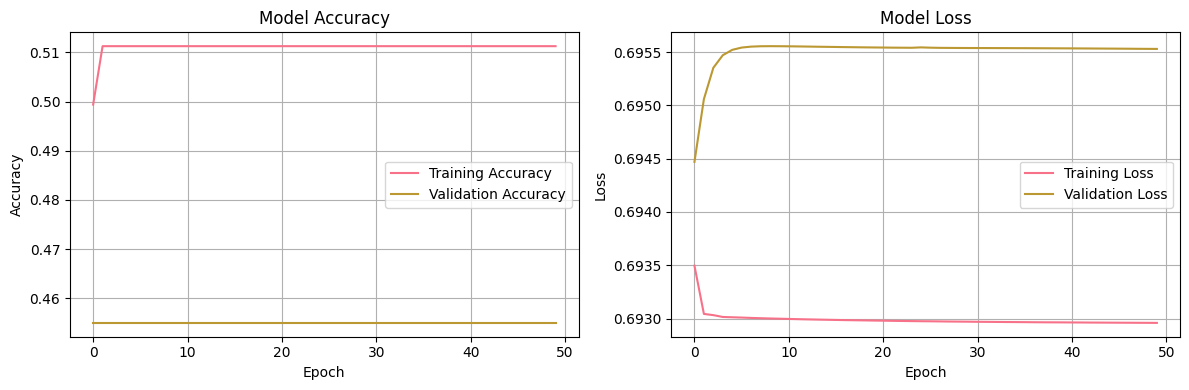


=== 최종 학습 결과 ===
학습 정확도: 0.5113
검증 정확도: 0.4550
학습 손실: 0.6930
검증 손실: 0.6955


In [33]:
# 학습 히스토리 시각화
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 최종 결과 출력
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n=== 최종 학습 결과 ===")
print(f"학습 정확도: {final_train_acc:.4f}")
print(f"검증 정확도: {final_val_acc:.4f}")
print(f"학습 손실: {final_train_loss:.4f}")
print(f"검증 손실: {final_val_loss:.4f}")


## 10. 모델 저장

학습된 모델을 저장합니다.


In [34]:
# 모델 저장
model_path = "../../data/models/catanddog.keras"
model.save(model_path)

print(f"모델이 '{model_path}'에 저장되었습니다!")
print(f"저장된 모델 크기: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

# 모델 정보 요약
print(f"\n=== 모델 정보 요약 ===")
print(f"모델 이름: 개와 고양이 분류 CNN")
print(f"입력 크기: (180, 180, 3)")
print(f"출력 크기: 1 (이진 분류)")
print(f"총 파라미터 수: {model.count_params():,}")
print(f"학습 에포크: 50")
print(f"최종 검증 정확도: {final_val_acc:.4f}")
print(f"모델 파일: {model_path}")


모델이 '../../data/models/catanddog.keras'에 저장되었습니다!
저장된 모델 크기: 19.34 MB

=== 모델 정보 요약 ===
모델 이름: 개와 고양이 분류 CNN
입력 크기: (180, 180, 3)
출력 크기: 1 (이진 분류)
총 파라미터 수: 1,684,705
학습 에포크: 50
최종 검증 정확도: 0.4550
모델 파일: ../../data/models/catanddog.keras


## 프로젝트 완료! 🎉

개와 고양이 분류 CNN 모델 구현이 완료되었습니다.

### 주요 구현 내용
✅ 데이터 전처리 및 증강  
✅ CNN 모델 설계  
✅ 모델 학습 및 검증  
✅ 학습 결과 시각화  
✅ 모델 저장  

### 다음 단계 제안
- 테스트 데이터셋으로 최종 평가 수행
- 더 복잡한 모델 아키텍처 실험 (ResNet, EfficientNet 등)
- 전이학습(Transfer Learning) 적용
- 모델 예측 결과 시각화
- 웹 애플리케이션으로 모델 배포

모델을 활용하여 새로운 이미지에 대한 예측을 수행해보세요!
